# SAM - Decoder finetuning

## Importing libraries

In [1]:
import numpy as np
import os
from PIL import Image

In [2]:
DATA_PATH = "/data/cvcqml/common/ycordero/kitti-mots"
INSTANCES_PATH = os.path.join(DATA_PATH, "instances")
TRAINING_PATH = os.path.join(DATA_PATH, "training")

BATCH_SIZE = 2
EPOCHS = 5

In [3]:
img = np.array(Image.open("/data/cvcqml/common/ycordero/kitti-mots/instances/0016/000000.png"))

obj_ids = np.unique(img)
class_ids = obj_ids // 1000

print(obj_ids)
print(class_ids)

[    0  1000  1001  1002  1003  2005  2006  2007  2022  2023  2024  2025
  2026 10000]
[ 0  1  1  1  1  2  2  2  2  2  2  2  2 10]


In [4]:
import numpy as np
from PIL import Image

def extract_instance_masks(annotation_path):
    """
    Extracts individual instance masks and their class IDs from a 16-bit PNG annotation file.
    
    Args:
        annotation_path (str): Path to the annotation PNG file.
        
    Returns:
        masks (dict): A dictionary where the keys are `(class_id, instance_id)` tuples,
                      and the values are binary masks of shape (H, W).
    """
    # Load the annotation image (16-bit, single-channel)
    img = np.array(Image.open(annotation_path))
    
    # Get unique object IDs
    obj_ids = np.unique(img)

    # Dictionary to store instance masks
    masks = {}
    for obj_id in obj_ids:
        if obj_id == 0:
            continue
        
        # Extract class_id and instance_id
        class_id = obj_id // 1000
        instance_id = obj_id % 1000

        # Generate binary mask for this specific object
        mask = (img == obj_id).astype(np.uint8)

        # Store mask in dictionary with (class_id, instance_id) as key
        masks[(class_id, instance_id)] = mask
    
    return masks

In [5]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence


class KITTIMOTSBaseDataset(Dataset):
    """
    Base dataset class for loading KITTI-MOTS images and instance masks.
    """
    def __init__(self, training_path, instances_path, split="train", transform=None, resize=None):
        """
        Args:
            training_path (str): Root directory of training/validation images (TRAINING_PATH)
            instances_path (str): Root directory of instance segmentation masks (INSTANCES_PATH)
            split (str): Either 'train' or 'val'
            transform (callable, optional): Optional transform to apply to images and masks
            resize (tuple, optional): If provided, resize all images and masks to this size (width, height)
        """
        self.split = split
        self.training_path = os.path.join(training_path, split)
        self.instances_path = instances_path
        self.transform = transform
        self.resize = resize
        
        # Collect image-mask pairs
        self.paired_data = self._match_images_and_masks()
        
    def _match_images_and_masks(self):
        """Match images with their corresponding instance masks."""
        paired_data = []
        
        # Traverse the training/val directory structure
        seq_dirs = [d for d in os.listdir(self.training_path) 
                    if os.path.isdir(os.path.join(self.training_path, d))]
        
        for seq_id in seq_dirs:
            img_dir = os.path.join(self.training_path, seq_id)
            mask_dir = os.path.join(self.instances_path, seq_id)
            
            # Skip if mask directory doesn't exist
            if not os.path.exists(mask_dir):
                print(f"Warning: Mask directory {mask_dir} not found. Skipping sequence {seq_id}.")
                continue
            
            # Get all image files in this sequence
            img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.png')])
            
            for img_file in img_files:
                img_path = os.path.join(img_dir, img_file)
                mask_path = os.path.join(mask_dir, img_file)
                
                # Check if corresponding mask exists
                if os.path.exists(mask_path):
                    paired_data.append((img_path, mask_path))
                else:
                    print(f"Warning: Mask not found for {img_path}")
        
        return paired_data
    
    def __len__(self):
        return len(self.paired_data)
    
    def __getitem__(self, idx):
        # Get image and mask paths
        img_path, mask_path = self.paired_data[idx]
        
        # Load image
        image = Image.open(img_path).convert("RGB")
        
        # Load mask (16-bit PNG)
        mask = np.array(Image.open(mask_path))
        
        # Process the mask to extract instance information
        instance_ids = np.unique(mask)[np.unique(mask) > 0]
        filtered_mask = np.zeros_like(mask, dtype=bool)
        for instance_id in instance_ids:
            class_id = instance_id // 1000
            if class_id in [1, 2]:
                filtered_mask = np.logical_or(filtered_mask, mask == instance_id)
        binary_mask = filtered_mask.astype(np.uint8)
        binary_mask_pil = Image.fromarray(binary_mask)
        
        # Apply resize if specified
        if self.resize:
            image = image.resize(self.resize, Image.BILINEAR)
            binary_mask_pil = binary_mask_pil.resize(self.resize, Image.NEAREST)
            binary_mask = np.array(binary_mask_pil)
        
        # Convert to numpy array after potential resize
        image_np = np.array(image)
        
        # Apply additional transforms if any
        if self.transform:
            image_np, binary_mask = self.transform(image_np, binary_mask)
        
        return {
            "image": image_np,
            "label": binary_mask,
            "image_path": img_path,
            "mask_path": mask_path,
            "original_mask": mask,
            "image_size": image_np.shape[:2]  # Store original size (H, W)
        }

def get_bounding_box(mask):
    """
    Calculate the bounding box coordinates for a binary mask.
    
    Args:
        mask (np.ndarray): Binary mask of shape (H, W)
        
    Returns:
        list: Bounding box coordinates [x_min, y_min, x_max, y_max]
    """
    # Find rows and columns where mask is True
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    
    # Handle empty mask case
    if not np.any(rows) or not np.any(cols):
        return [0, 0, 0, 0]
    
    # Get min/max indices for rows and columns
    y_min, y_max = np.where(rows)[0][[0, -1]]
    x_min, x_max = np.where(cols)[0][[0, -1]]
    
    return [int(x_min), int(y_min), int(x_max), int(y_max)]

class SAMDataset(Dataset):
    """
    This class is used to create a dataset that serves input images and masks
    formatted specifically for SAM2.
    """
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor
        
    def __len__(self):
        return len(self.dataset)
        
    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        ground_truth_mask = np.array(item["label"])
        
        # Get bounding box prompt
        prompt = get_bounding_box(ground_truth_mask)
        
        # Prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")
        
        # Remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}
        
        # Add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask
        
        # Optionally pass through additional information
        inputs["image_path"] = item["image_path"]
        inputs["mask_path"] = item["mask_path"]
        inputs["image_size"] = item["image_size"]
        
        return inputs

def custom_collate_fn(batch):
    """
    Custom collate function that handles variable-sized images and masks.
    This function:
    1. Processes SAM2-specific tensor inputs (pixel_values, etc.) 
    2. Pads ground_truth_masks to the same size
    3. Collects non-tensor items (paths, etc.)
    """
    # Group data by key
    grouped_data = {key: [item[key] for item in batch] for key in batch[0].keys()}
    
    # Determine max dimensions for padding
    if "ground_truth_mask" in grouped_data:
        masks = grouped_data["ground_truth_mask"]
        max_h = max(mask.shape[0] for mask in masks)
        max_w = max(mask.shape[1] for mask in masks)
        
        # Pad masks to the same size
        padded_masks = []
        for mask in masks:
            h, w = mask.shape
            padded = np.zeros((max_h, max_w), dtype=mask.dtype)
            padded[:h, :w] = mask
            padded_masks.append(torch.as_tensor(padded))
        
        grouped_data["ground_truth_mask"] = torch.stack(padded_masks)
    
    # Process tensor data
    for key in list(grouped_data.keys()):
        if key == "ground_truth_mask":
            continue  # Already processed
        elif isinstance(grouped_data[key][0], torch.Tensor):
            # Handle tensor data (from processor)
            # For tensors with same shape, stack them
            try:
                grouped_data[key] = torch.stack(grouped_data[key])
            except:
                # For tensors with different shapes, use appropriate method
                if len(grouped_data[key][0].shape) <= 1:  # 1D tensors
                    grouped_data[key] = pad_sequence(grouped_data[key], batch_first=True)
                else:
                    # For tensors with different shapes that can't be stacked,
                    # create a dict with "_batch_idx" suffix to maintain the batch structure
                    for i, tensor in enumerate(grouped_data[key]):
                        grouped_data[f"{key}_batch_idx_{i}"] = tensor
                    # Remove the original key which is a list
                    del grouped_data[key]
        elif isinstance(grouped_data[key][0], (str, tuple)):
            # For strings and tuples, create a new entry with batch index
            for i, item in enumerate(grouped_data[key]):
                grouped_data[f"{key}_batch_idx_{i}"] = item
            del grouped_data[key]
        elif isinstance(grouped_data[key][0], list):
            # For lists, convert to tensors if they contain numbers
            try:
                # Try to convert to a tensor
                grouped_data[key] = torch.tensor(grouped_data[key])
            except:
                # If it fails, create individual entries
                for i, item in enumerate(grouped_data[key]):
                    grouped_data[f"{key}_batch_idx_{i}"] = torch.tensor(item) if isinstance(item[0], (int, float)) else item
                del grouped_data[key]
        else:
            # Try to convert to tensor if possible, otherwise create individual entries
            try:
                grouped_data[key] = torch.tensor(grouped_data[key])
            except:
                for i, item in enumerate(grouped_data[key]):
                    grouped_data[f"{key}_batch_idx_{i}"] = item
                del grouped_data[key]
    
    return grouped_data

# Example usage:
def load_sam2_datasets(training_path, instances_path, processor, batch_size=2, resize=None):
    """
    Load train and validation datasets formatted for SAM2.
    
    Args:
        training_path (str): Path to training images
        instances_path (str): Path to instance masks
        processor: SAM2 processor for input preparation
        batch_size (int): Batch size for DataLoader
        resize (tuple, optional): If provided, resize all images to this size (width, height)
        
    Returns:
        train_loader, val_loader: DataLoaders for train and validation sets
    """
    # Create base datasets
    train_base = KITTIMOTSBaseDataset(
        training_path=training_path,
        instances_path=instances_path,
        split="train",
        resize=resize
    )
    
    val_base = KITTIMOTSBaseDataset(
        training_path=training_path,
        instances_path=instances_path,
        split="val",
        resize=resize
    )
    
    # Wrap with SAM2 dataset
    train_dataset = SAMDataset(dataset=train_base, processor=processor)
    val_dataset = SAMDataset(dataset=val_base, processor=processor)
    
    # Create data loaders with custom collate function if resize is None
    if resize is None:
        train_loader = DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            shuffle=True, 
            collate_fn=custom_collate_fn
        )
        val_loader = DataLoader(
            val_dataset, 
            batch_size=batch_size, 
            shuffle=False, 
            collate_fn=custom_collate_fn
        )
    else:
        # If using fixed resize, standard collate function is fine
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, train_dataset, val_dataset

In [6]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
train_loader, val_loader, train_dataset, val_dataset = load_sam2_datasets(TRAINING_PATH, INSTANCES_PATH, processor, resize=(256, 256), batch_size=BATCH_SIZE)

/data/cvcqml/common/ycordero/mcv-c5-team1-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
batch = next(iter(train_loader))
batch["ground_truth_mask"].shape

/data/cvcqml/common/ycordero/mcv-c5-team1-env/lib/python3.12/site-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


torch.Size([2, 256, 256])

In [8]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [9]:
from torch.optim import Adam
import monai

# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [10]:
from tqdm import tqdm
from statistics import mean
import torch

#Training loop
num_epochs = EPOCHS

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_loader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

  0%|          | 0/2514 [00:00<?, ?it/s]/data/cvcqml/common/ycordero/mcv-c5-team1-env/lib/python3.12/site-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)
100%|██████████| 2514/2514 [19:17<00:00,  2.17it/s]


EPOCH: 0
Mean loss: 0.1499292440299395


100%|██████████| 2514/2514 [19:19<00:00,  2.17it/s]


EPOCH: 1
Mean loss: 0.1057721523519221


100%|██████████| 2514/2514 [19:22<00:00,  2.16it/s]


EPOCH: 2
Mean loss: 0.0944127578662661


100%|██████████| 2514/2514 [19:18<00:00,  2.17it/s]


EPOCH: 3
Mean loss: 0.08696332461179909


100%|██████████| 2514/2514 [19:18<00:00,  2.17it/s]

EPOCH: 4
Mean loss: 0.08221783608867948


In [15]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "./mito_model_checkpoint.pth")

## Inference

In [16]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [17]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("./mito_model_checkpoint.pth"))

# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

Using device: cuda


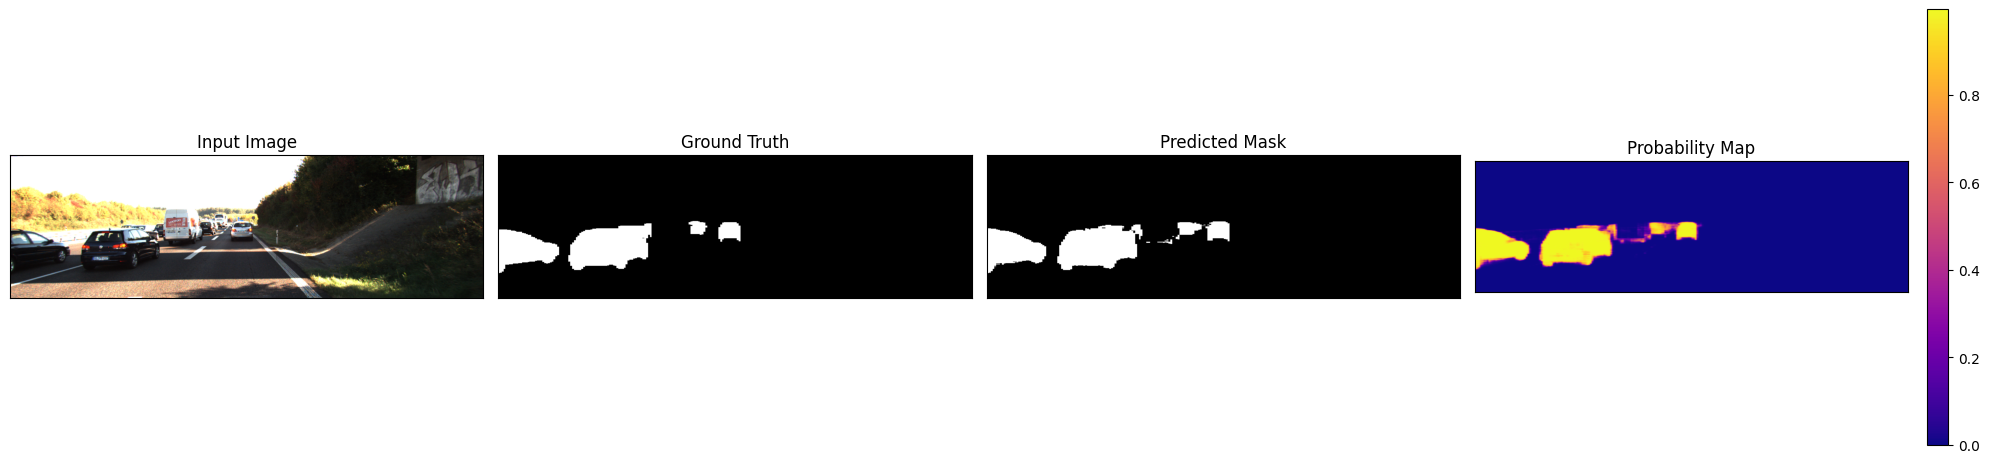

In [35]:
# Import necessary libraries
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from PIL import Image

# Function to visualize a random example from your dataset
def visualize_random_example(train_dataset, processor, model, device):
    """
    Visualize a random example from the dataset with model predictions.
    
    Args:
        train_dataset: Your SAMDataset instance
        processor: SAM processor for input preparation
        model: SAM model instance
        device: torch device (cuda or cpu)
    
    Returns:
        tuple: (original_image, ground_truth, predicted_mask, probability_map)
    """
    # Choose a random index
    idx = random.randint(0, len(train_dataset)-1)
    
    # Get the sample directly from the dataset (not the DataLoader)
    sample = train_dataset[idx]
    
    # Extract image and ground truth mask
    image_path = sample["image_path"]
    test_image = np.array(Image.open(image_path).convert("RGB"))
    ground_truth_mask = sample["ground_truth_mask"]
    
    # Get the original prompt that was used (bounding box)
    if "input_boxes" in sample:
        # For tensors, properly extract the coordinates
        if isinstance(sample["input_boxes"], torch.Tensor):
            if sample["input_boxes"].dim() == 1:  # Shape (4,)
                prompt = sample["input_boxes"].tolist()
            elif sample["input_boxes"].dim() == 2:  # Shape (1, 4)
                prompt = sample["input_boxes"][0].tolist()
            else:  # Shape (batch, boxes, 4)
                prompt = sample["input_boxes"][0, 0].tolist()
        else:  # For lists
            prompt = sample["input_boxes"][0] if isinstance(sample["input_boxes"][0], list) else sample["input_boxes"]
    else:
        # Or recalculate it if needed
        prompt = get_bounding_box(ground_truth_mask)
    
    # Prepare image + box prompt for the model
    # If sample already has processed inputs, use those
    if "pixel_values" in sample:
        # Create a new dictionary with just the model inputs
        inputs = {k: v for k, v in sample.items() if k in ["pixel_values", "input_boxes", "input_points", "input_labels"]}
        
        # Handle input_boxes specifically to ensure correct shape (batch_size, nb_boxes, 4)
        if "input_boxes" in inputs:
            # If input_boxes is a 1D tensor of shape (4,), reshape to (1, 1, 4)
            if inputs["input_boxes"].dim() == 1:
                inputs["input_boxes"] = inputs["input_boxes"].unsqueeze(0).unsqueeze(0)
            # If input_boxes is a 2D tensor of shape (1, 4), reshape to (1, 1, 4)
            elif inputs["input_boxes"].dim() == 2:
                inputs["input_boxes"] = inputs["input_boxes"].unsqueeze(1)
        
        # Add batch dimension to pixel_values if needed
        if "pixel_values" in inputs and inputs["pixel_values"].dim() == 3:
            inputs["pixel_values"] = inputs["pixel_values"].unsqueeze(0)
    else:
        # Or process the image again
        inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")
    
    # Move inputs to device
    inputs = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in inputs.items()}
    
    # Run inference
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)
    
    # Apply sigmoid for soft mask
    seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    
    # Convert to numpy and create binary mask
    seg_prob_np = seg_prob.cpu().numpy().squeeze()
    binary_seg = (seg_prob_np > 0.5).astype(np.uint8)

    # Get original image dimensions
    original_height, original_width = test_image.shape[:2]
    
    # Resize ground truth mask to match original image
    if ground_truth_mask.shape != (original_height, original_width):
        ground_truth_pil = Image.fromarray(ground_truth_mask.astype(np.uint8))
        ground_truth_pil = ground_truth_pil.resize((original_width, original_height), Image.NEAREST)
        ground_truth_mask = np.array(ground_truth_pil)
    
    # Resize prediction and probability map to match original image
    if binary_seg.shape != (original_height, original_width):
        binary_seg_pil = Image.fromarray(binary_seg)
        binary_seg_pil = binary_seg_pil.resize((original_width, original_height), Image.NEAREST) 
        binary_seg = np.array(binary_seg_pil)
        
        seg_prob_np_pil = Image.fromarray((seg_prob_np * 255).astype(np.uint8))
        seg_prob_np_pil = seg_prob_np_pil.resize((original_width, original_height), Image.BILINEAR)
        seg_prob_np = np.array(seg_prob_np_pil) / 255.0
    
    # Visualize results
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Original image
    axes[0].imshow(test_image)
    axes[0].set_title("Input Image")
    
    # Ground truth mask
    axes[1].imshow(ground_truth_mask, cmap='gray')
    axes[1].set_title("Ground Truth")
    
    # Predicted binary mask
    axes[2].imshow(binary_seg, cmap='gray')
    axes[2].set_title("Predicted Mask")
    
    # Probability map
    im = axes[3].imshow(seg_prob_np, cmap='plasma')
    axes[3].set_title("Probability Map")
    plt.colorbar(im, ax=axes[3], fraction=0.046, pad=0.04)
    
    # Add bounding box to the original image
    if "input_boxes" in sample:
        x_min, y_min, x_max, y_max = prompt
        rect = plt.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, 
                             linewidth=2, edgecolor='r', facecolor='none')
        axes[0].add_patch(rect)
    
    # Remove axis ticks and labels
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.tight_layout()
    plt.show()
    
    return test_image, ground_truth_mask, binary_seg, seg_prob_np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Visualize a random example
test_image, ground_truth, prediction, prob_map = visualize_random_example(train_dataset, processor, my_mito_model, device)
